# samv2

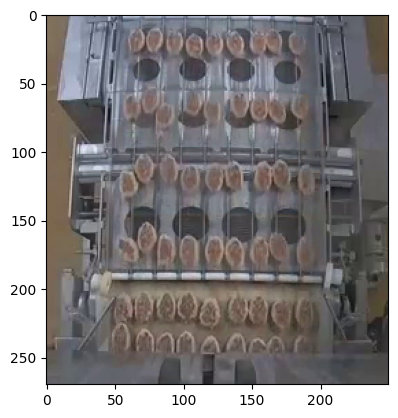

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import requests
from PIL import Image

img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/images/train/frame_002388.PNG"

img = Image.open(img_path)
img = np.array(img.convert("RGB"))

img = img[30:300, 200:450]

plt.imshow(img)

In [9]:
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator
from sam2.build_sam import build_sam2

sam2_checkpoint = "../models/sam2.1_hiera_small.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_s.yaml"


model = build_sam2(model_cfg, sam2_checkpoint, device='cpu')

mask_generator = SAM2AutomaticMaskGenerator(
    model,
    points_per_side=32,           # Increased from default 32
    pred_iou_thresh=0.7,          # Lowered from default 0.8
    stability_score_thresh=0.85,  # Lowered from default 0.95
    box_nms_thresh=0.6,           # Lowered from default 0.7
    )



In [10]:
masks = mask_generator.generate(img)

In [11]:
print(len(masks))
print(masks[0].keys())
print(masks[0]['segmentation'].shape)
print(img.shape)


108
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])
(270, 250)
(270, 250, 3)


In [12]:
from typing import Optional, Union, List, Dict

import numpy as np
from PIL import Image


def show_masks_fixed(
    image: np.ndarray,
    masks: Union[np.ndarray, List[Dict]],
    scores: Optional[np.ndarray] = None,
    alpha: Optional[float] = 0.5,
    display_image: Optional[bool] = True,  # Changed default to True
    only_best: Optional[bool] = True,
    autogenerated_mask: Optional[bool] = False,
) -> Image.Image:
    """
    Display segmentation masks on an image.
    
    Parameters:
        image (np.ndarray): Input image as a numpy array.
        masks (np.ndarray or List[Dict]): Either a numpy array of masks or a list of dictionaries
                                         with "segmentation" and "area" keys.
        scores (np.ndarray, optional): Confidence scores for masks.
        alpha (float, optional): Transparency of masks. Default is 0.5.
        display_image (bool, optional): Whether to display masks on the input image. Default is False.
        only_best (bool, optional): Whether to only display the mask with highest score. Default is True.
        autogenerated_mask (bool, optional): Whether masks are in autogenerated format. Default is False.
        
    Returns:
        PIL.Image.Image: Image with overlaid masks
    """
    # Handle sorting by scores if provided
    if scores is not None and not autogenerated_mask:
        # Sort masks by their scores
        sorted_ind = np.argsort(scores)[::-1]
        masks = masks[sorted_ind]

    # Get dimensions from the input
    if display_image:
        # Use the input image dimensions
        if image.ndim == 3:  # Color image
            h, w = image.shape[:2]
        else:  # Grayscale image
            h, w = image.shape
    elif autogenerated_mask:
        # For autogenerated masks, get dimensions from the first mask
        if isinstance(masks, list) and masks and 'segmentation' in masks[0]:
            h, w = masks[0]['segmentation'].shape
        else:
            raise ValueError("Autogenerated masks should be a list of dictionaries with 'segmentation' key")
    else:
        # For regular masks, get dimensions from the mask array
        if masks.ndim == 3:  # Multiple masks
            h, w = masks.shape[1:]
        else:  # Single mask
            h, w = masks.shape

    # Prepare the output image
    if display_image:
        # Convert input image to PIL and ensure RGBA mode
        if image.dtype == np.uint8:
            output_image = Image.fromarray(image)
        else:
            output_image = Image.fromarray((image * 255).astype(np.uint8))
            
        if output_image.mode != 'RGBA':
            output_image = output_image.convert('RGBA')
    else:
        # Create a new blank image
        output_image = Image.new(mode="RGBA", size=(w, h), color=(0, 0, 0, 0))  # Fully transparent
        
        # If we have the original image, blend it in even when display_image is False
        # This ensures masks are displayed on top of the original image
        if image is not None:
            img_pil = Image.fromarray(image if image.dtype == np.uint8 else (image * 255).astype(np.uint8))
            if img_pil.mode != 'RGBA':
                img_pil = img_pil.convert('RGBA')
            # Resize if needed
            if img_pil.size != output_image.size:
                img_pil = img_pil.resize((w, h))
            output_image = img_pil.copy()

    # Process each mask
    if autogenerated_mask:
        # Sort by area if autogenerated
        if isinstance(masks, list) and masks and 'area' in masks[0]:
            masks = sorted(masks, key=(lambda x: x["area"]), reverse=True)
    
    # Iterate through masks
    mask_count = len(masks) if isinstance(masks, list) else masks.shape[0]
    for i in range(mask_count):
        if autogenerated_mask:
            if isinstance(masks, list) and 'segmentation' in masks[i]:
                mask = masks[i]["segmentation"]
            else:
                raise ValueError("Expected masks to be a list of dicts with 'segmentation' key when autogenerated_mask=True")
        else:
            if masks.ndim > 2:
                mask = masks[i]
                if mask.ndim > 2:  # Handle extra dimensions
                    mask = mask.squeeze()
            else:
                mask = masks  # Single mask case

        # Generate a random color with specified alpha value
        color = np.concatenate(
            (np.random.randint(0, 256, size=3), [int(alpha * 255)]), axis=0
        )

        # Create an RGBA image for the mask
        # Ensure mask has values 0-1 for binary mask
        if mask.dtype != np.bool_:
            if np.max(mask) > 1.0:
                mask = (mask > 0).astype(np.uint8)
            else:
                mask = (mask > 0.5).astype(np.uint8)
        
        # Print debug info (uncomment if needed)
        # print(f"Mask shape: {mask.shape}, Output image size: {output_image.size}")
        
        # Ensure mask dimensions match output_image dimensions (width×height in PIL)
        expected_h, expected_w = output_image.size[1], output_image.size[0]
        if mask.shape[0] != expected_h or mask.shape[1] != expected_w:
            # Resize mask to match output_image dimensions
            # Note: NumPy and PIL have different dimension ordering
            mask_resized = np.zeros((expected_h, expected_w), dtype=mask.dtype)
            # Copy values where possible
            min_h = min(mask.shape[0], expected_h)
            min_w = min(mask.shape[1], expected_w)
            mask_resized[:min_h, :min_w] = mask[:min_h, :min_w]
            mask = mask_resized
                
        mask_image = Image.fromarray((mask * 255).astype(np.uint8)).convert("L")
        mask_colored = Image.new("RGBA", mask_image.size, tuple(color))
        mask_overlay = Image.new("RGBA", mask_image.size, (0, 0, 0, 0))
        mask_image = Image.composite(mask_colored, mask_overlay, mask_image)

        # Overlay mask on the output image
        output_image = Image.alpha_composite(output_image, mask_image)

        # Exit if specified to only display the best mask
        if only_best:
            break

    return output_image

In [13]:
output_mask = show_masks_fixed(image = img, masks = masks, scores=None, only_best=False, autogenerated_mask=True)

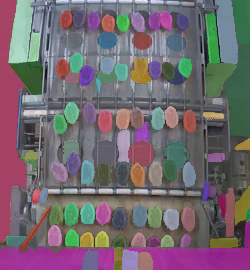

In [14]:
output_mask

# Sparse models

In [82]:
def create_transparent_mask_overlay(image, masks, alpha=0.4, color=[255, 0, 0]):
    """
    Creates a semi-transparent overlay of masks on an image.
    
    Args:
        image: PIL Image or numpy array of the original image
        masks: List of binary masks (numpy arrays or PIL Images)
        alpha: Transparency level of the overlay (0.0 to 1.0)
        color: RGB color list for the mask overlay [R, G, B]
        
    Returns:
        PIL Image with transparent mask overlay
    """
    # Convert image to numpy array if it's a PIL Image
    if isinstance(image, Image.Image):
        image_array = np.array(image)
    else:
        image_array = image.copy()
    
    # Make sure image is in RGB format (convert from grayscale if needed)
    if len(image_array.shape) == 2:
        # Convert grayscale to RGB
        image_array = np.stack([image_array] * 3, axis=2)
    elif len(image_array.shape) == 3 and image_array.shape[2] == 4:
        # If image has alpha channel, keep only RGB
        image_array = image_array[:, :, :3]
    
    # Create a blank RGBA array for the mask overlay
    # (RGB for color + Alpha for transparency)
    mask_overlay = np.zeros((*image_array.shape[:2], 4), dtype=np.uint8)
    
    # Set the RGB values to the specified color
    mask_overlay[:, :, 0] = color[0]  # R
    mask_overlay[:, :, 1] = color[1]  # G
    mask_overlay[:, :, 2] = color[2]  # B
    
    # Start with fully transparent overlay
    mask_overlay[:, :, 3] = 0  # Alpha channel (0 = transparent)
    
    # Process each mask
    for mask in masks:
        # Convert mask to numpy array if it's a PIL Image
        if isinstance(mask, Image.Image):
            mask_array = np.array(mask)
        else:
            mask_array = mask.copy()
        
        # Ensure mask is boolean
        if mask_array.dtype != bool:
            mask_array = mask_array > 0
        
        # Make sure mask has the same shape as the image
        if mask_array.shape != image_array.shape[:2]:
            # Create a new mask of the correct size
            temp_mask = np.zeros(image_array.shape[:2], dtype=bool)
            
            # Handle size differences
            h = min(mask_array.shape[0], image_array.shape[0])
            w = min(mask_array.shape[1], image_array.shape[1])
            
            # Copy the correct portion of the mask
            temp_mask[:h, :w] = mask_array[:h, :w]
            mask_array = temp_mask
        
        # Set alpha channel to semi-transparent for masked regions
        mask_overlay[:, :, 3][mask_array] = int(alpha * 255)
    
    # Convert arrays to PIL Images
    original_image = Image.fromarray(image_array)
    overlay_image = Image.fromarray(mask_overlay)
    
    # Paste the overlay onto the original image using the alpha channel as mask
    result = original_image.copy()
    result.paste(overlay_image, (0, 0), overlay_image)
    
    return result

def visualize_masks(image, masks, figsize=(12, 8)):
    """
    Visualize original image, masks, and transparent overlay in one figure.
    
    Args:
        image: PIL Image or numpy array
        masks: List of binary masks
        figsize: Figure size for matplotlib
    """
    # Create the transparent overlay
    overlay_image = create_transparent_mask_overlay(image, masks)
    
    # Convert images to numpy arrays if they're PIL Images
    if isinstance(image, Image.Image):
        image_array = np.array(image)
    else:
        image_array = image.copy()
        
    if len(image_array.shape) == 2:
        # Convert grayscale to RGB
        image_array = np.stack([image_array] * 3, axis=2)
    
    # Create a combined mask for visualization
    if masks:
        combined_mask = np.zeros(image_array.shape[:2], dtype=bool)
        for mask in masks:
            mask_array = np.array(mask) if isinstance(mask, Image.Image) else mask
            
            # Handle size differences
            h = min(mask_array.shape[0], combined_mask.shape[0])
            w = min(mask_array.shape[1], combined_mask.shape[1])
            temp = np.zeros_like(combined_mask)
            temp[:h, :w] = mask_array[:h, :w] > 0
            
            combined_mask = combined_mask | temp
    else:
        combined_mask = np.zeros(image_array.shape[:2], dtype=bool)
    
    # Create the figure
    fig, axes = plt.subplots(1, 3, figsize=figsize)
    
    # Display original image
    axes[0].imshow(image_array)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Display combined mask
    axes[1].imshow(combined_mask, cmap='Reds')
    axes[1].set_title('Masks')
    axes[1].axis('off')
    
    # Display overlay image
    axes[2].imshow(np.array(overlay_image))
    axes[2].set_title('Transparent Overlay')
    axes[2].axis('off')
    
    plt.tight_layout()
    plt.show()

In [83]:
import numpy as np
import cv2

def load_yolo_masks_as_binary_list(txt_path, img_width, img_height):
    """
    Load YOLO segmentation masks from a .txt file and convert each line to a separate binary mask.
    
    Args:
        txt_path (str): Path to the YOLO segmentation .txt file
        img_width (int): Width of the original image
        img_height (int): Height of the original image
        
    Returns:
        list: List of binary masks (np.ndarray), one for each line in the txt file
    """
    # Read the YOLO segmentation file
    with open(txt_path, 'r') as f:
        lines = f.readlines()
    
    # List to store individual masks
    masks = []
    
    for line in lines:
        # Skip empty lines
        if not line.strip():
            continue
            
        # Create an empty mask for this line
        mask = np.zeros((img_height, img_width), dtype=np.uint8)
        
        # Split the line into values
        values = line.strip().split()
        
        # In YOLO format, the first value is the class ID, which we'll ignore
        # The rest are x,y coordinates in normalized form (0-1)
        polygon_points = values[1:]
        
        # Convert to numpy array and reshape to pairs of x,y coordinates
        polygon_points = np.array(polygon_points, dtype=float).reshape(-1, 2)
        
        # Convert normalized coordinates (0-1) to pixel coordinates
        polygon_points[:, 0] *= img_width  # x coordinates
        polygon_points[:, 1] *= img_height  # y coordinates
        
        # Convert to integer points for drawing
        polygon_points = polygon_points.astype(np.int32)
        
        # Draw the filled polygon onto the mask
        cv2.fillPoly(mask, [polygon_points], 1)
        
        # Add this mask to our list
        masks.append(mask)

        # Add this debugging before returning masks
        for i, mask in enumerate(masks):
            if 0 in mask.shape:
                print(f"Warning: Mask {i} has invalid dimensions: {mask.shape}")
                # Optionally fix masks with zero dimensions by creating small valid mask
                masks[i] = np.zeros((img_height, img_width), dtype=np.uint8)
    
    return masks

In [96]:
import sys
import os

# Get the absolute path to the repo root (parent of both src and notebook folders)
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))

# Add the repo root to the Python path
sys.path.append(repo_root)

# Now you can import from src
from src.master.model import MultiLayerFeatureKNN

knn = MultiLayerFeatureKNN(layers=[2, 4, 6, 8], metric="cosine", pca_variance=0.99)

c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [97]:
img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/images/train/frame_000000.PNG"
label_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/labels/train/frame_000000.txt"

img1 = Image.open(img_path)
img1 = np.array(img1.convert("RGB"))

positive_image1 = img1[30:300, 200:450]

img_w, img_h, _ = positive_image1.shape

positive_masks1 = load_yolo_masks_as_binary_list(label_path, img_w, img_h)

In [98]:
img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/images/train/frame_001044.PNG"
label_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/labels/train/frame_001044.txt"

img2 = Image.open(img_path)
img2 = np.array(img2.convert("RGB"))

positive_image2 = img2[30:300, 200:450]

img_w, img_h, _ = positive_image2.shape

positive_masks2 = load_yolo_masks_as_binary_list(label_path, img_w, img_h)

In [99]:
positive_images = [positive_image1, positive_image2]
positive_masks = [positive_masks1, positive_masks2]

In [100]:
knn.fit(positive_images, positive_masks)




Reduced feature dimension from 896 to 77 with 99.0% variance preserved


True

In [101]:
img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/meatballs/images/train/frame_002388.PNG"

img = Image.open(img_path)
img = np.array(img.convert("RGB"))

test_image = img[30:300, 200:450]

In [102]:
candidate_masks = []

for mask in masks:
    bi_mask = mask["segmentation"]
    candidate_masks. append(bi_mask)

In [103]:
filtered_masks, similarity_scores = knn.predict(test_image, candidate_masks)


knn.cleanup()

Using statistical threshold: 0.654


In [104]:
# Create pairs of (mask, score)
mask_score_pairs = list(zip(filtered_masks, similarity_scores))

# Sort the pairs based on scores in descending order (highest score first)
sorted_pairs = sorted(mask_score_pairs, key=lambda x: x[1], reverse=True)

# Unzip the sorted pairs
sorted_masks, sorted_scores = zip(*sorted_pairs) if sorted_pairs else ([], [])

# Convert back to lists if needed
sorted_masks = list(sorted_masks)
sorted_scores = list(sorted_scores)

[np.float64(0.7169572007642839), np.float64(0.7138870823918636), np.float64(0.7055252917322268), np.float64(0.7053275205052674), np.float64(0.694835689550108), np.float64(0.6927779315171176), np.float64(0.6927191988940974), np.float64(0.6883155091302111), np.float64(0.6852479173041003), np.float64(0.6851398873567803), np.float64(0.6840144861977977), np.float64(0.6837683635314921), np.float64(0.6837654892277265), np.float64(0.6829860740534044), np.float64(0.6823326199572198), np.float64(0.6803166391562117), np.float64(0.6780219511021476), np.float64(0.6778290410095996), np.float64(0.6762436838463464), np.float64(0.6746825367191804), np.float64(0.6745698744428319), np.float64(0.6744351694758445), np.float64(0.6737643137984829), np.float64(0.673534576089911), np.float64(0.6734402834636677), np.float64(0.673387891978766), np.float64(0.6728655383379667), np.float64(0.6710340587570498), np.float64(0.6709983743076866), np.float64(0.6707276191931165), np.float64(0.670593406900158), np.float64(

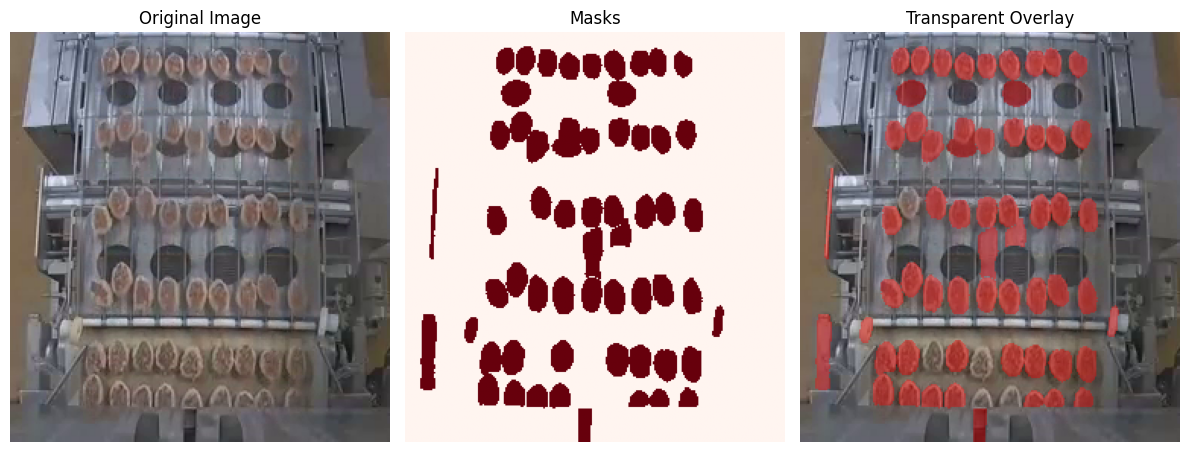

In [105]:
print(sorted_scores)
print(len(candidate_masks))
print(len(filtered_masks))

visualize_masks(test_image, sorted_masks[:60])

In [106]:
print(len(positive_masks1))

51


In [107]:
import random

random.seed(42)

sub_positives = random.sample(positive_masks1, 20)

knn = MultiLayerFeatureKNN(n_neighbors=5, metric="cosine", layers=[2, 4, 6, 8], pca_variance=0.99)

knn.fit(positive_image1, sub_positives)

filtered_masks, similarity_scores = knn.predict(test_image, candidate_masks)

knn.cleanup()

# Create pairs of (mask, score)
mask_score_pairs = list(zip(filtered_masks, similarity_scores))

# Sort the pairs based on scores in descending order (highest score first)
sorted_pairs = sorted(mask_score_pairs, key=lambda x: x[1], reverse=True)

# Unzip the sorted pairs
sorted_masks, sorted_scores = zip(*sorted_pairs) if sorted_pairs else ([], [])

# Convert back to lists if needed
sorted_masks = list(sorted_masks)
sorted_scores = list(sorted_scores)


c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Reduced feature dimension from 896 to 18 with 99.0% variance preserved
Using statistical threshold: 0.787


[np.float64(0.6892237949387652), np.float64(0.6855661156428975), np.float64(0.683182842397193), np.float64(0.6745390909566761), np.float64(0.6718603832704918), np.float64(0.6676240938831163), np.float64(0.665695218524683), np.float64(0.665264089896993), np.float64(0.6630208474136314), np.float64(0.6621062964522771), np.float64(0.6616251024984418), np.float64(0.6611886777411834), np.float64(0.6595698594555083), np.float64(0.6594158587405984), np.float64(0.6586367559700711), np.float64(0.6576484606088793), np.float64(0.6570440100137406), np.float64(0.6564531761699205), np.float64(0.656449934512938), np.float64(0.6554991315161531), np.float64(0.655085732656371), np.float64(0.654636504866727), np.float64(0.6542103987684568), np.float64(0.6535720478471656), np.float64(0.6534820816941971), np.float64(0.6522375535094204), np.float64(0.6521295965468743), np.float64(0.650962618533369), np.float64(0.6491962484943938), np.float64(0.6491869397132183), np.float64(0.6471627586642853), np.float64(0.6

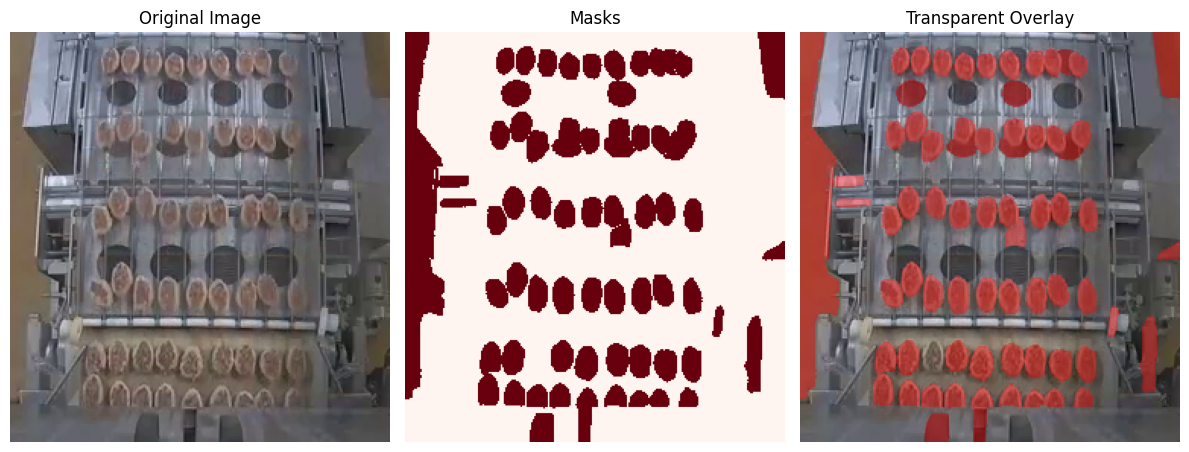

In [108]:
print(sorted_scores)
print(len(candidate_masks))
print(len(filtered_masks))

visualize_masks(test_image, sorted_masks[:70])

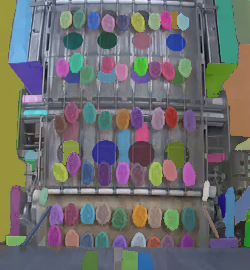

In [109]:
output_mask

# Can

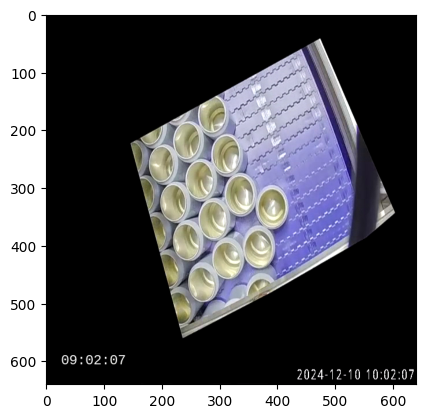

In [120]:
img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/cans/images/train/frame_000147.PNG"

img = Image.open(img_path)
test_image = np.array(img.convert("RGB"))

plt.imshow(img)

In [121]:
masks = mask_generator.generate(test_image)

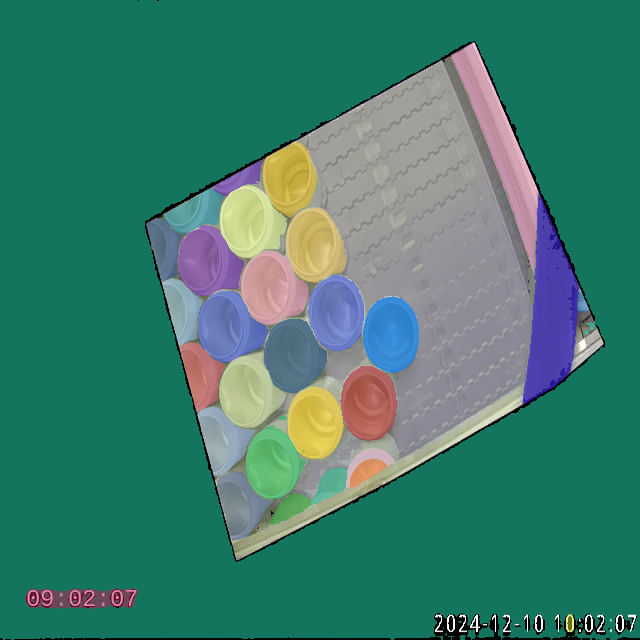

In [123]:
output_mask = show_masks_fixed(image = test_image, masks = masks, scores=None, only_best=False, autogenerated_mask=True)

output_mask

In [124]:
candidate_masks = []

for mask in masks:
    bi_mask = mask["segmentation"]
    candidate_masks.append(bi_mask)

In [125]:
img_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/cans/images/train/frame_000392.PNG"
label_path = "C:/Users/GustavToft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/processed/cans/labels/train/frame_000392.txt"

img1 = Image.open(img_path)
img1 = np.array(img1.convert("RGB"))

positive_image1 = img1

img_w, img_h, _ = positive_image1.shape

positive_masks1 = load_yolo_masks_as_binary_list(label_path, img_w, img_h)

In [126]:
knn = MultiLayerFeatureKNN(n_neighbors=5, metric="cosine", layers=[2, 4, 6, 8], pca_variance=0.99)

knn.fit(positive_image1, positive_masks1)

filtered_masks, similarity_scores = knn.predict(test_image, candidate_masks)

knn.cleanup()

# Create pairs of (mask, score)
mask_score_pairs = list(zip(filtered_masks, similarity_scores))

# Sort the pairs based on scores in descending order (highest score first)
sorted_pairs = sorted(mask_score_pairs, key=lambda x: x[1], reverse=True)

# Unzip the sorted pairs
sorted_masks, sorted_scores = zip(*sorted_pairs) if sorted_pairs else ([], [])

# Convert back to lists if needed
sorted_masks = list(sorted_masks)
sorted_scores = list(sorted_scores)

c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Reduced feature dimension from 896 to 25 with 99.0% variance preserved
Using statistical threshold: 0.681


[np.float64(0.7936298958154832), np.float64(0.7707229918760258), np.float64(0.7534981104152557), np.float64(0.7175540492005509), np.float64(0.7156347678023904), np.float64(0.7141553731139578), np.float64(0.7136570472875525), np.float64(0.706942701491466), np.float64(0.7024532575990862), np.float64(0.7012022677372783), np.float64(0.6970435176928675), np.float64(0.6953542547894718), np.float64(0.6940327828138553), np.float64(0.6823841386290506), np.float64(0.6782826294548531), np.float64(0.6765479444766147), np.float64(0.675466571089041), np.float64(0.6746447546402641), np.float64(0.6743064291709868), np.float64(0.6721143150169816), np.float64(0.670930212072806), np.float64(0.6703376265965287), np.float64(0.6607247140954619), np.float64(0.6597663702336586), np.float64(0.6416309817284778), np.float64(0.6401333578524248), np.float64(0.6384087500868172), np.float64(0.6282870160956519), np.float64(0.6256099278547844), np.float64(0.6230273903703928), np.float64(0.6222052845662287), np.float64

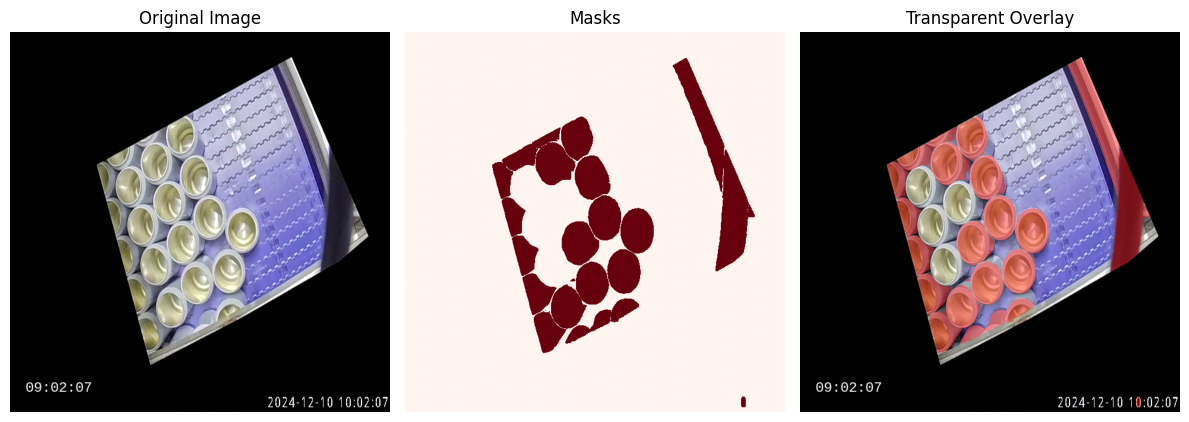

In [132]:
print(sorted_scores)
print(len(candidate_masks))
print(len(filtered_masks))

visualize_masks(test_image, sorted_masks[:25])